# COLMAP-SLAM Video Processing Demo

This notebook demonstrates how to use the COLMAP-SLAM pipeline to process video files and generate 3D reconstructions.

## Overview
The pipeline will:
1. Extract frames from input video
2. Run SLAM reconstruction
3. Export 3D point cloud and camera trajectory
4. Visualize results

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import subprocess
from datetime import datetime

# Add COLMAP_SLAM to path
sys.path.append('/workspace/modules/COLMAP_SLAM')

from pipeline import Pipeline
from src import enums

print("✓ Imports successful")
print(f"Available feature extractors: {[e.name for e in enums.Extractors]}")
print(f"Available feature matchers: {[e.name for e in enums.Matchers]}")

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


✓ Imports successful
Available feature extractors: ['SuperPoint', 'ORB']
Available feature matchers: ['SuperGlue', 'OrbHamming']


## Configuration

Set up the processing parameters and file paths.

In [2]:
# Configuration parameters
CONFIG = {
    # Video processing
    'frame_skip': 5,                    # Extract every Nth frame
    'max_frames': 100,                  # Maximum frames to process (None for all)
    'resize_factor': 1.0,               # Resize frames (1.0 = no resize)
    
    # SLAM parameters
    'init_frames': 30,                  # Frames for initialization
    'optical_flow_threshold': 0.05,     # Keyframe selection threshold
    'extractor': enums.Extractors.SuperPoint,  # SuperPoint or ORB
    'matcher': enums.Matchers.SuperGlue,       # SuperGlue or OrbHamming
    
    # Paths
    'video_dir': '/workspace/videos',
    'output_dir': '/workspace/outputs',
    'temp_dir': '/workspace/temp'
}

# Create directories
for dir_path in [CONFIG['output_dir'], CONFIG['temp_dir']]:
    os.makedirs(dir_path, exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  frame_skip: 5
  max_frames: 100
  resize_factor: 1.0
  init_frames: 30
  optical_flow_threshold: 0.05
  extractor: Extractors.SuperPoint
  matcher: Matchers.SuperGlue
  video_dir: /workspace/videos
  output_dir: /workspace/outputs
  temp_dir: /workspace/temp


## Video Processing Functions

In [3]:
def extract_frames_from_video(video_path, output_dir, frame_skip=1, max_frames=None, resize_factor=1.0):
    """
    Extract frames from video file.
    
    Args:
        video_path: Path to input video
        output_dir: Directory to save frames
        frame_skip: Extract every Nth frame
        max_frames: Maximum number of frames to extract
        resize_factor: Factor to resize frames
    
    Returns:
        Number of frames extracted
    """
    os.makedirs(output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video properties:")
    print(f"  Total frames: {total_frames}")
    print(f"  FPS: {fps:.2f}")
    print(f"  Resolution: {width}x{height}")
    
    frame_count = 0
    extracted_count = 0
    
    # Calculate new dimensions if resizing
    if resize_factor != 1.0:
        new_width = int(width * resize_factor)
        new_height = int(height * resize_factor)
        print(f"  Resizing to: {new_width}x{new_height}")
    
    pbar = tqdm(total=min(total_frames // frame_skip, max_frames or float('inf')), 
                desc="Extracting frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_skip == 0:
            # Resize if needed
            if resize_factor != 1.0:
                frame = cv2.resize(frame, (new_width, new_height))
            
            # Save frame
            frame_filename = f"frame{extracted_count:06d}.jpg"
            frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(frame_path, frame)
            
            extracted_count += 1
            pbar.update(1)
            
            if max_frames and extracted_count >= max_frames:
                break
        
        frame_count += 1
    
    cap.release()
    pbar.close()
    
    print(f"Extracted {extracted_count} frames to {output_dir}")
    return extracted_count


def list_video_files(video_dir):
    """List all video files in directory."""
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm']
    video_files = []
    
    if os.path.exists(video_dir):
        for file in os.listdir(video_dir):
            if any(file.lower().endswith(ext) for ext in video_extensions):
                video_files.append(os.path.join(video_dir, file))
    
    return sorted(video_files)


def create_output_structure(base_output_dir, video_name):
    """Create organized output directory structure."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{video_name}_{timestamp}"
    
    output_structure = {
        'base': os.path.join(base_output_dir, run_name),
        'frames': os.path.join(base_output_dir, run_name, 'frames'),
        'reconstruction': os.path.join(base_output_dir, run_name, 'reconstruction'),
        'visualization': os.path.join(base_output_dir, run_name, 'visualization')
    }
    
    for path in output_structure.values():
        os.makedirs(path, exist_ok=True)
    
    return output_structure

print("✓ Video processing functions defined")

✓ Video processing functions defined


## SLAM Processing Functions

In [4]:
def run_slam_pipeline(frames_dir, output_dir, config):
    """
    Run the COLMAP-SLAM pipeline on extracted frames.
    
    Args:
        frames_dir: Directory containing input frames
        output_dir: Directory for reconstruction output
        config: Configuration dictionary
    
    Returns:
        Pipeline object with reconstruction results
    """
    print("Initializing SLAM pipeline...")
    
    # Create pipeline
    pipeline = Pipeline(
        extractor=config['extractor'],
        matcher=config['matcher']
    )
    
    # Load data
    print(f"Loading frames from: {frames_dir}")
    pipeline.load_data(
        images=frames_dir,
        outputs=output_dir,
        exports="reconstruction.ply",
        init_max_num_images=config['init_frames'],
        frame_skip=1,  # Already skipped during extraction
        max_frame=-1   # Process all extracted frames
    )
    
    print(f"Loaded {len(pipeline.frame_names)} frames for processing")
    
    # Run SLAM
    print("Running SLAM reconstruction...")
    print(f"Using {config['extractor'].name} features and {config['matcher'].name} matching")
    
    pipeline.run(optical_flow_threshold=config['optical_flow_threshold'])
    
    # Print results
    print("\nReconstruction complete!")
    print(pipeline.reconstruction.summary())
    
    return pipeline


def export_results(pipeline, output_dir):
    """
    Export reconstruction results in various formats.
    
    Args:
        pipeline: SLAM pipeline object
        output_dir: Directory to save exports
    """
    print("Exporting reconstruction results...")
    
    # Export COLMAP binary files
    colmap_dir = os.path.join(output_dir, 'colmap')
    os.makedirs(colmap_dir, exist_ok=True)
    pipeline.reconstruction.write(colmap_dir)
    print(f"✓ COLMAP files saved to: {colmap_dir}")
    
    # Export trajectory (already done by pipeline)
    traj_file = os.path.join(output_dir, 'estimation.txt')
    if os.path.exists(traj_file):
        print(f"✓ Camera trajectory saved to: {traj_file}")
    
    # Export PLY point cloud
    try:
        ply_file = os.path.join(output_dir, 'pointcloud.ply')
        pipeline.reconstruction.export_PLY(ply_file)
        print(f"✓ Point cloud saved to: {ply_file}")
    except Exception as e:
        print(f"⚠ Could not export PLY: {e}")
    
    # Generate summary report
    summary_file = os.path.join(output_dir, 'reconstruction_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("COLMAP-SLAM Reconstruction Summary\n")
        f.write("=" * 40 + "\n\n")
        f.write(pipeline.reconstruction.summary())
        f.write("\n\nConfiguration:\n")
        for key, value in CONFIG.items():
            f.write(f"{key}: {value}\n")
    
    print(f"✓ Summary report saved to: {summary_file}")

print("✓ SLAM processing functions defined")

✓ SLAM processing functions defined


## Visualization Functions

In [5]:
def plot_camera_trajectory(pipeline, output_dir):
    """
    Plot and save camera trajectory visualization.
    
    Args:
        pipeline: SLAM pipeline object
        output_dir: Directory to save plots
    """
    if len(pipeline.reconstruction.images) == 0:
        print("No registered images to plot")
        return
    
    # Extract camera positions
    positions = []
    image_ids = []
    
    for img_id in sorted(pipeline.reconstruction.images.keys()):
        image = pipeline.reconstruction.images[img_id]
        # Camera center in world coordinates
        center = -image.rotmat().T @ image.tvec
        positions.append(center)
        image_ids.append(img_id)
    
    positions = np.array(positions)
    
    # Create 3D trajectory plot
    fig = plt.figure(figsize=(15, 5))
    
    # 3D plot
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', alpha=0.7)
    ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=range(len(positions)), cmap='viridis', s=20)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Camera Trajectory')
    
    # Top view (X-Y)
    ax2 = fig.add_subplot(132)
    ax2.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.7)
    ax2.scatter(positions[:, 0], positions[:, 1], c=range(len(positions)), cmap='viridis', s=20)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Top View (X-Y)')
    ax2.axis('equal')
    
    # Side view (X-Z)
    ax3 = fig.add_subplot(133)
    ax3.plot(positions[:, 0], positions[:, 2], 'b-', alpha=0.7)
    ax3.scatter(positions[:, 0], positions[:, 2], c=range(len(positions)), cmap='viridis', s=20)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Z')
    ax3.set_title('Side View (X-Z)')
    ax3.axis('equal')
    
    plt.tight_layout()
    
    # Save plot
    plot_file = os.path.join(output_dir, 'camera_trajectory.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Camera trajectory plot saved to: {plot_file}")
    
    # Print trajectory statistics
    total_distance = np.sum(np.linalg.norm(np.diff(positions, axis=0), axis=1))
    bbox_size = np.max(positions, axis=0) - np.min(positions, axis=0)
    
    print(f"Trajectory statistics:")
    print(f"  Total path length: {total_distance:.3f} units")
    print(f"  Bounding box size: {bbox_size}")
    print(f"  Number of poses: {len(positions)}")


def plot_reconstruction_stats(pipeline, output_dir):
    """
    Plot reconstruction statistics.
    
    Args:
        pipeline: SLAM pipeline object
        output_dir: Directory to save plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Number of observations per point
    if len(pipeline.reconstruction.points3D) > 0:
        obs_counts = [len(point.track.elements) for point in pipeline.reconstruction.points3D.values()]
        axes[0,0].hist(obs_counts, bins=20, alpha=0.7)
        axes[0,0].set_xlabel('Number of Observations')
        axes[0,0].set_ylabel('Number of Points')
        axes[0,0].set_title('Point Observation Distribution')
    
    # Track lengths
    if len(pipeline.reconstruction.points3D) > 0:
        track_lengths = obs_counts  # Same as observations
        axes[0,1].hist(track_lengths, bins=20, alpha=0.7, color='orange')
        axes[0,1].set_xlabel('Track Length')
        axes[0,1].set_ylabel('Number of Tracks')
        axes[0,1].set_title('Track Length Distribution')
    
    # Image registration order
    if len(pipeline.reconstruction.images) > 0:
        image_ids = sorted(pipeline.reconstruction.images.keys())
        axes[1,0].plot(range(len(image_ids)), image_ids, 'o-')
        axes[1,0].set_xlabel('Registration Order')
        axes[1,0].set_ylabel('Image ID')
        axes[1,0].set_title('Image Registration Order')
    
    # Point cloud extent
    if len(pipeline.reconstruction.points3D) > 0:
        points = np.array([point.xyz for point in pipeline.reconstruction.points3D.values()])
        axes[1,1].scatter(points[:, 0], points[:, 1], alpha=0.5, s=1)
        axes[1,1].set_xlabel('X')
        axes[1,1].set_ylabel('Y')
        axes[1,1].set_title('Point Cloud (Top View)')
        axes[1,1].axis('equal')
    
    plt.tight_layout()
    
    # Save plot
    plot_file = os.path.join(output_dir, 'reconstruction_stats.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Reconstruction statistics plot saved to: {plot_file}")

print("✓ Visualization functions defined")

✓ Visualization functions defined


## Main Processing Pipeline

Select and process a video file through the complete SLAM pipeline.

In [6]:
# List available video files
video_files = list_video_files(CONFIG['video_dir'])

print(f"Found {len(video_files)} video files in {CONFIG['video_dir']}:")
for i, video_file in enumerate(video_files):
    file_size = os.path.getsize(video_file) / (1024*1024)  # MB
    print(f"  {i}: {os.path.basename(video_file)} ({file_size:.1f} MB)")

if len(video_files) == 0:
    print("\n⚠ No video files found!")
    print(f"Please place video files in: {CONFIG['video_dir']}")
    print("Supported formats: .mp4, .avi, .mov, .mkv, .wmv, .flv, .webm")
else:
    print(f"\n📁 To process a video, run the next cell and select a video by index (0-{len(video_files)-1})")

Found 1 video files in /workspace/videos:
  0: drone1.mp4 (118.0 MB)

📁 To process a video, run the next cell and select a video by index (0-0)


In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Interactive video selection
if len(video_files) > 0:
    # Create dropdown widget with video options
    video_options = [(f"{os.path.basename(video)} ({os.path.getsize(video)/(1024*1024):.1f} MB)", i) 
                     for i, video in enumerate(video_files)]
    
    video_dropdown = widgets.Dropdown(
        options=video_options,
        value=0,
        description='Select video:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )
    
    select_button = widgets.Button(
        description="Process Selected Video",
        button_style='primary',
        layout=widgets.Layout(width='200px')
    )
    
    output_area = widgets.Output()
    
    def on_select_clicked(b):
        with output_area:
            clear_output()
            video_index = video_dropdown.value
            
            global selected_video, video_name, outputs
            selected_video = video_files[video_index]
            video_name = os.path.splitext(os.path.basename(selected_video))[0]
            
            print(f"✅ Selected video: {os.path.basename(selected_video)}")
            print(f"📝 Video name: {video_name}")
            
            # Create output structure
            outputs = create_output_structure(CONFIG['output_dir'], video_name)
            
            print(f"\n📁 Output directories created:")
            for key, path in outputs.items():
                print(f"  {key}: {path}")
            
            print(f"\n🎬 Ready to process! Run the next cell to extract frames.")
    
    select_button.on_click(on_select_clicked)
    
    print("🎯 Select a video to process:")
    display(video_dropdown)
    display(select_button)
    display(output_area)
    
else:
    print("❌ No video files available to process")
    print(f"Please place video files in: {CONFIG['video_dir']}")
    print("Supported formats: .mp4, .avi, .mov, .mkv, .wmv, .flv, .webm")

🎯 Select a video to process:


Dropdown(description='Select video:', layout=Layout(width='500px'), options=(('drone1.mp4 (118.0 MB)', 0),), s…

Button(button_style='primary', description='Process Selected Video', layout=Layout(width='200px'), style=Butto…

Output()

## Step 1: Extract Frames

🎬 Extracting frames from: drone1.mp4
Video properties:
  Total frames: 950
  FPS: 24.00
  Resolution: 3840x2160


Extracting frames: 100% 100/100 [00:12<00:00,  7.79it/s]


Extracted 100 frames to /workspace/outputs/drone1_20250917_154527/frames

✅ Frame extraction complete!
Extracted 100 frames to: /workspace/outputs/drone1_20250917_154527/frames


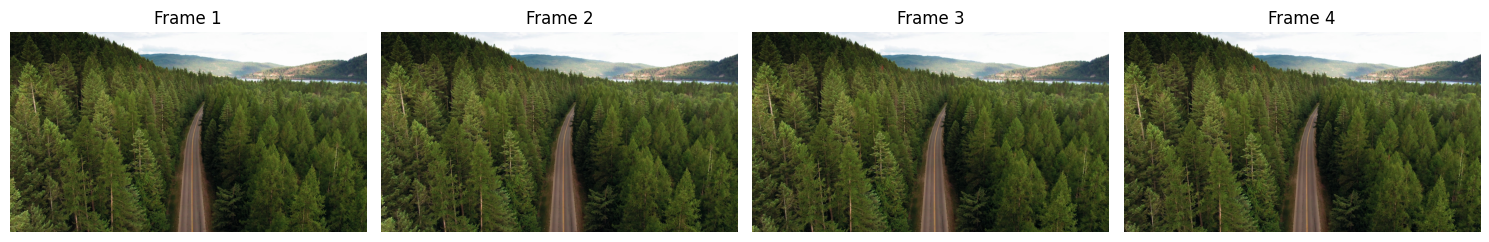

In [13]:
if 'selected_video' in locals():
    print(f"🎬 Extracting frames from: {os.path.basename(selected_video)}")
    
    # Extract frames
    num_frames = extract_frames_from_video(
        video_path=selected_video,
        output_dir=outputs['frames'],
        frame_skip=CONFIG['frame_skip'],
        max_frames=CONFIG['max_frames'],
        resize_factor=CONFIG['resize_factor']
    )
    
    print(f"\n✅ Frame extraction complete!")
    print(f"Extracted {num_frames} frames to: {outputs['frames']}")
    
    # Show sample frames
    frame_files = sorted(os.listdir(outputs['frames']))[:4]  # Show first 4 frames
    
    if frame_files:
        fig, axes = plt.subplots(1, min(4, len(frame_files)), figsize=(15, 4))
        if len(frame_files) == 1:
            axes = [axes]
        
        for i, frame_file in enumerate(frame_files):
            if i >= 4:
                break
            frame_path = os.path.join(outputs['frames'], frame_file)
            img = cv2.imread(frame_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if len(frame_files) > 1:
                axes[i].imshow(img_rgb)
                axes[i].set_title(f"Frame {i+1}")
                axes[i].axis('off')
            else:
                axes.imshow(img_rgb)
                axes.set_title(f"Frame 1")
                axes.axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("❌ No video selected. Please run the video selection cell first.")

## Step 2: Run SLAM Reconstruction

In [ ]:
if 'outputs' in locals() and 'num_frames' in locals():
    print(f"🚀 Starting SLAM reconstruction...")
    print(f"Processing {num_frames} frames from: {outputs['frames']}")
    
    try:
        # Run SLAM pipeline
        pipeline = run_slam_pipeline(
            frames_dir=outputs['frames'],
            output_dir=outputs['reconstruction'],
            config=CONFIG
        )
        
        print("\n🎉 SLAM reconstruction completed successfully!")
        print(f"Results saved to: {outputs['reconstruction']}")
        
        # Export results
        export_results(pipeline, outputs['reconstruction'])
        
    except Exception as e:
        print(f"❌ SLAM reconstruction failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Frames not extracted yet. Please run the frame extraction step first.")

## Step 3: Visualize Results

In [10]:
if 'pipeline' in locals():
    print("📊 Generating visualizations...")
    
    # Plot camera trajectory
    plot_camera_trajectory(pipeline, outputs['visualization'])
    
    # Plot reconstruction statistics
    plot_reconstruction_stats(pipeline, outputs['visualization'])
    
    print("\n✅ Visualization complete!")
    print(f"Plots saved to: {outputs['visualization']}")
else:
    print("❌ No reconstruction results available. Please run the SLAM step first.")

❌ No reconstruction results available. Please run the SLAM step first.


## Results Summary

In [11]:
if 'pipeline' in locals() and 'outputs' in locals():
    print("📋 RECONSTRUCTION SUMMARY")
    print("=" * 50)
    
    print(f"Input video: {os.path.basename(selected_video)}")
    print(f"Processed frames: {num_frames}")
    print(f"Output directory: {outputs['base']}")
    
    print("\nReconstruction statistics:")
    print(pipeline.reconstruction.summary())
    
    print("\nGenerated files:")
    
    # List key output files
    key_files = [
        (outputs['reconstruction'], 'colmap/cameras.bin', 'COLMAP camera parameters'),
        (outputs['reconstruction'], 'colmap/images.bin', 'COLMAP image poses'),
        (outputs['reconstruction'], 'colmap/points3D.bin', 'COLMAP 3D points'),
        (outputs['reconstruction'], 'estimation.txt', 'Camera trajectory (TUM format)'),
        (outputs['reconstruction'], 'reconstruction_summary.txt', 'Detailed summary'),
        (outputs['visualization'], 'camera_trajectory.png', 'Trajectory visualization'),
        (outputs['visualization'], 'reconstruction_stats.png', 'Statistics plots')
    ]
    
    for base_dir, rel_path, description in key_files:
        full_path = os.path.join(base_dir, rel_path)
        if os.path.exists(full_path):
            size = os.path.getsize(full_path)
            if size > 1024*1024:
                size_str = f"{size/(1024*1024):.1f} MB"
            elif size > 1024:
                size_str = f"{size/1024:.1f} KB"
            else:
                size_str = f"{size} B"
            print(f"  ✓ {rel_path} ({size_str}) - {description}")
        else:
            print(f"  ✗ {rel_path} - {description} (not found)")
    
    print(f"\n🎯 All results saved to: {outputs['base']}")
    print(f"📁 This directory is mounted to the host at: ./outputs/{os.path.basename(outputs['base'])}")
else:
    print("❌ No results to summarize. Please complete the reconstruction pipeline first.")

❌ No results to summarize. Please complete the reconstruction pipeline first.


## Advanced: Batch Processing Multiple Videos

Uncomment and run the cell below to process all videos in the input directory.

In [12]:
# # Batch process all videos (uncomment to use)
# if len(video_files) > 1:
#     print(f"🔄 Batch processing {len(video_files)} videos...")
#     
#     for i, video_path in enumerate(video_files):
#         print(f"\n{'='*50}")
#         print(f"Processing video {i+1}/{len(video_files)}: {os.path.basename(video_path)}")
#         print(f"{'='*50}")
#         
#         try:
#             video_name = os.path.splitext(os.path.basename(video_path))[0]
#             batch_outputs = create_output_structure(CONFIG['output_dir'], video_name)
#             
#             # Extract frames
#             num_frames = extract_frames_from_video(
#                 video_path=video_path,
#                 output_dir=batch_outputs['frames'],
#                 frame_skip=CONFIG['frame_skip'],
#                 max_frames=CONFIG['max_frames'],
#                 resize_factor=CONFIG['resize_factor']
#             )
#             
#             # Run SLAM
#             batch_pipeline = run_slam_pipeline(
#                 frames_dir=batch_outputs['frames'],
#                 output_dir=batch_outputs['reconstruction'],
#                 config=CONFIG
#             )
#             
#             # Export and visualize
#             export_results(batch_pipeline, batch_outputs['reconstruction'])
#             plot_camera_trajectory(batch_pipeline, batch_outputs['visualization'])
#             plot_reconstruction_stats(batch_pipeline, batch_outputs['visualization'])
#             
#             print(f"✅ Video {i+1} completed successfully")
#             
#         except Exception as e:
#             print(f"❌ Video {i+1} failed: {e}")
#             continue
#     
#     print(f"\n🎉 Batch processing completed!")
# else:
#     print("Only one video available - use single video processing instead")